# Statistics from geopandas data

Calculate building statistics from a `geopandas` `GeoDataFrame`.


In [28]:
import geopandas as gpd
import matplotlib.pyplot as plt
import seaborn as sns
from cityseer.metrics import layers
from cityseer.tools import graphs, io
import numpy as np


To start, follow the same approach as shown in the network examples to create the network.


In [2]:
streets_gpd = gpd.read_file("data/madrid_streets/street_network.gpkg")
streets_gpd = streets_gpd.explode(reset_index=True)
G = io.nx_from_generic_geopandas(streets_gpd)
G = graphs.nx_decompose(G, 50)
G_dual = graphs.nx_to_dual(G)
nodes_gdf, _edges_gdf, network_structure = io.network_structure_from_nx(G_dual)

INFO:cityseer.tools.graphs:Merging parallel edges within buffer of 1.
INFO:cityseer.tools.graphs:Decomposing graph to maximum edge lengths of 50.
INFO:cityseer.tools.graphs:Converting graph to dual.
INFO:cityseer.tools.graphs:Preparing dual nodes
INFO:cityseer.tools.graphs:Preparing dual edges (splitting and welding geoms)
INFO:cityseer.tools.io:Preparing node and edge arrays from networkX graph.
INFO:cityseer.graph:Edge R-tree built successfully with 195313 items.


Read-in the dataset from the source Geopackage or Shapefile Geopandas.


In [3]:
bldgs_gpd = gpd.read_file("data/madrid_buildings/madrid_bldgs.gpkg")
bldgs_gpd.head()

,mean_height,area,perimeter,compactness,orientation,volume,floor_area_ratio,form_factor,corners,shape_index,fractal_dimension,geometry
0,NaN,187.418714,58.669276,0.491102,40.235999,NaN,NaN,NaN,4,0.700787,1.026350,"POLYGON ((448688.642 4492911, 448678.351 44928..."
1,7.0,39.082821,26.992208,0.472874,10.252128,273.579749,78.165643,5.410857,4,0.687658,1.041691,"POLYGON ((440862.665 4482604.017, 440862.64 44..."
2,7.0,39.373412,27.050303,0.475086,10.252128,275.613883,78.746824,5.400665,4,0.689265,1.040760,"POLYGON ((440862.681 4482608.269, 440862.665 4..."
3,7.5,37.933979,26.739878,0.464266,10.252129,284.504846,75.867959,5.513124,4,0.681371,1.045072,"POLYGON ((440862.705 4482612.365, 440862.681 4..."
4,7.0,39.013701,26.972641,0.472468,10.183618,273.095907,78.027402,5.412350,4,0.687363,1.041798,"POLYGON ((440880.29 4482607.963, 440880.274 44..."


Use the [`layers.compute_stats`](https://cityseer.benchmarkurbanism.com/metrics/layers#compute-stats) method to compute statistics for numeric columns in the `GeoDataFrame`. These are specified with the `stats_column_labels` argument. These statistics are computed over the network using network distances. In the case of weighted variances, the contribution of any particular point is weighted by the distance from the point of measure.


In [4]:
distances = [100, 200]
nodes_gdf, bldgs_gpd = layers.compute_stats(
    bldgs_gpd,
    stats_column_labels=[
        "area",
        "perimeter",
        "compactness",
        "orientation",
        "shape_index",
    ],
    nodes_gdf=nodes_gdf,
    network_structure=network_structure,
    distances=distances,
)

INFO:cityseer.metrics.layers:Computing statistics.
INFO:cityseer.metrics.layers:Assigning data to network.
INFO:cityseer.data:Assigning 135302 data entries to network nodes (max_dist: 100).
INFO:cityseer.data:Finished assigning data. 1282627 assignments added to 89639 nodes.
INFO:cityseer.config:Metrics computed for:
INFO:cityseer.config:Distance: 100m, Beta: 0.04, Walking Time: 1.25 minutes.
INFO:cityseer.config:Distance: 200m, Beta: 0.02, Walking Time: 2.5 minutes.


This will generate a set of columns containing `count`, `sum`, `min`, `max`, `mean`, `median`, `MAD` (deviation from the median) and `var`, in unweighted `nw` and weighted `wt` versions (where applicable) for each of the input distance thresholds.


In [29]:
list(nodes_gdf.columns)

['ns_node_idx',
 'x',
 'y',
 'live',
 'weight',
 'primal_edge',
 'primal_edge_node_a',
 'primal_edge_node_b',
 'primal_edge_idx',
 'dual_node',
 'cc_area_sum_100_nw',
 'cc_area_sum_100_wt',
 'cc_area_mean_100_nw',
 'cc_area_mean_100_wt',
 'cc_area_count_100_nw',
 'cc_area_count_100_wt',
 'cc_area_median_100_nw',
 'cc_area_median_100_wt',
 'cc_area_var_100_nw',
 'cc_area_var_100_wt',
 'cc_area_mad_100_nw',
 'cc_area_mad_100_wt',
 'cc_area_max_100',
 'cc_area_min_100',
 'cc_area_sum_200_nw',
 'cc_area_sum_200_wt',
 'cc_area_mean_200_nw',
 'cc_area_mean_200_wt',
 'cc_area_count_200_nw',
 'cc_area_count_200_wt',
 'cc_area_median_200_nw',
 'cc_area_median_200_wt',
 'cc_area_var_200_nw',
 'cc_area_var_200_wt',
 'cc_area_mad_200_nw',
 'cc_area_mad_200_wt',
 'cc_area_max_200',
 'cc_area_min_200',
 'cc_perimeter_sum_100_nw',
 'cc_perimeter_sum_100_wt',
 'cc_perimeter_mean_100_nw',
 'cc_perimeter_mean_100_wt',
 'cc_perimeter_count_100_nw',
 'cc_perimeter_count_100_wt',
 'cc_perimeter_median_100_

The result in columns can be explored with conventional Python ecosystem tools such as `seaborn` and `matplotlib`.


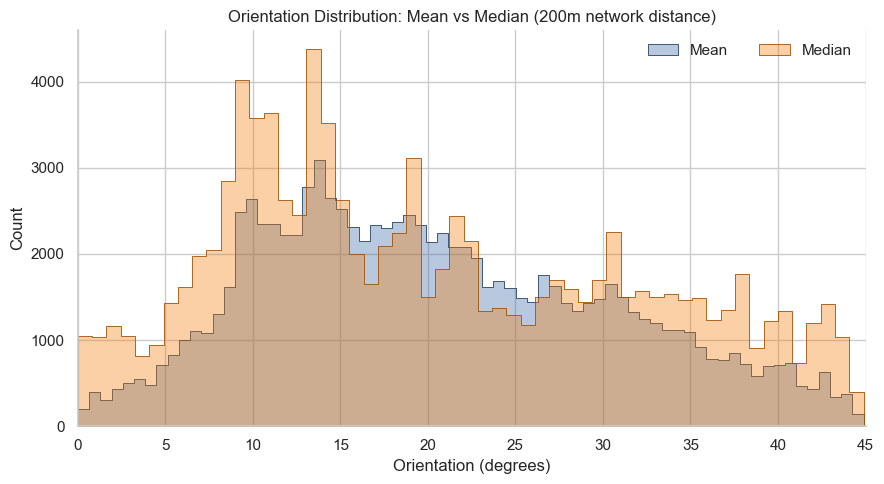

In [36]:
fig, ax = plt.subplots(figsize=(9, 5))

sns.histplot(
    data=nodes_gdf,
    x="cc_orientation_mean_200_nw",
    color="#3465a4",
    alpha=0.35,
    edgecolor="#23425f",
    linewidth=0.6,
    label="Mean",
    element="step",
    ax=ax,
)

sns.histplot(
    data=nodes_gdf,
    x="cc_orientation_median_200_nw",
    color="#f57900",
    alpha=0.35,
    edgecolor="#a55000",
    linewidth=0.6,
    label="Median",
    element="step",
    ax=ax,
)

ax.set_xlabel("Orientation (degrees)")
ax.set_ylabel("Count")
ax.set_title("Orientation Distribution: Mean vs Median (200m network distance)")
ax.legend(frameon=False, ncol=2)

ax.set_xlim(0, 45)

sns.despine()
plt.tight_layout()


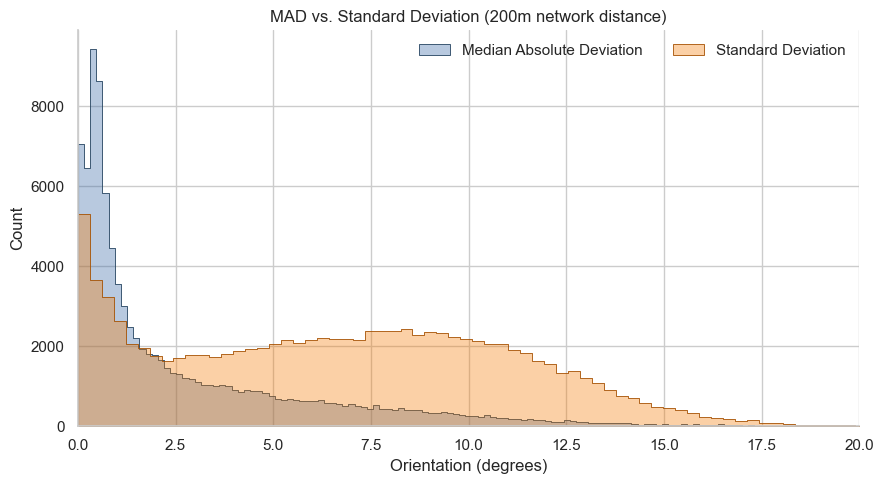

In [58]:
fig, ax = plt.subplots(figsize=(9, 5))

sns.histplot(
    data=nodes_gdf,
    x="cc_orientation_mad_200_nw",
    color="#3465a4",
    alpha=0.35,
    edgecolor="#23425f",
    linewidth=0.6,
    label="Median Absolute Deviation",
    element="step",
    ax=ax,
)

nodes_gdf["std"] = np.sqrt(nodes_gdf["cc_orientation_var_200_nw"])
sns.histplot(
    data=nodes_gdf,
    x="std",
    color="#f57900",
    alpha=0.35,
    edgecolor="#a55000",
    linewidth=0.6,
    label="Standard Deviation",
    element="step",
    ax=ax,
)

ax.set_xlabel("Orientation (degrees)")
ax.set_ylabel("Count")
ax.set_title("MAD vs. Standard Deviation (200m network distance)")
ax.legend(frameon=False, ncol=2)

ax.set_xlim(0, 20)

sns.despine()
plt.tight_layout()


(np.float64(438500.0),
 np.float64(442000.0),
 np.float64(4472500.0),
 np.float64(4476000.0))

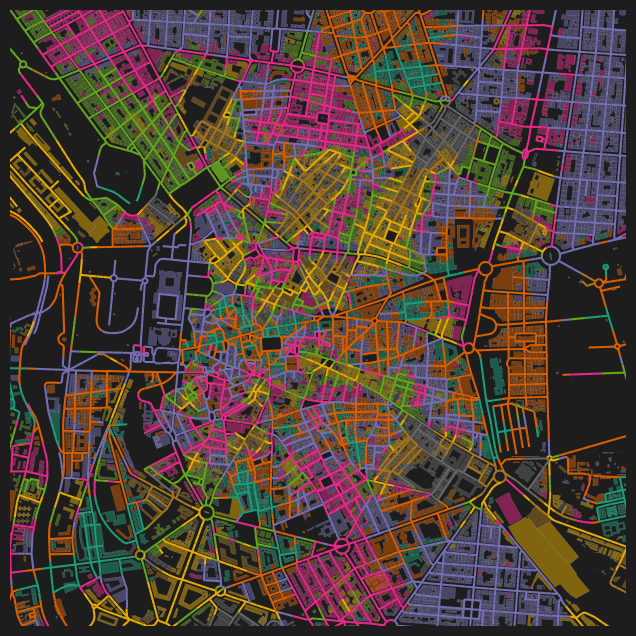

In [44]:
fig, ax = plt.subplots(1, 1, figsize=(8, 8), facecolor="#1d1d1d")
nodes_gdf.plot(
    column="cc_orientation_median_200_wt",
    cmap="Dark2",
    legend=False,
    vmin=0,
    vmax=45,
    ax=ax,
)
bldgs_gpd.plot(
    column="orientation",
    cmap="Dark2",
    legend=False,
    vmin=0,
    vmax=45,
    linewidth=0.1,
    alpha=0.5,
    ax=ax,
)
ax.set_xlim(438500, 438500 + 3500)
ax.set_ylim(4472500, 4472500 + 3500)
ax.axis(False)
